# Regulatory Genomics Lecture Exercise

## Install the dependencies

In addition to the pre-installed packages like numpy, pandas, matplotlib, keras, tensorflow, we'll install concise, a keras extension for regulatory genomics developed in the Gagneur lab: https://github.com/gagneurlab/concise.

In [ ]:
! pip install concise

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import concise
from concise.preprocessing import encodeDNA
from concise.utils import PWM

from concise.utils.plot import seqlogo, seqlogo_fig

/opt/modules/i12g/anaconda/3-5.0.1/envs/splicing/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# Used additional packages
%matplotlib inline

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

## Load simulated data

## Get the data

We are going to use simulated data of 10,000 500 bp long sequences with the positive set containing an instance of the TAL1 motif:
![TAL1 known4](http://compbio.mit.edu/encode-motifs/logos/table/logos/small/rev/TAL1_known4.png)
and the negative set will be random sequences. The data were simulated using simDNA https://github.com/kundajelab/simdna by Johnny Israeli and were deposited to https://github.com/kundajelab/dragonn.

In [5]:
!wget 'https://github.com/kundajelab/dragonn/raw/master/paper_supplement/simulation_data/GC_fraction0.4motif_nameTAL1_known4num_neg10000num_pos10000seq_length500.npz'

--2018-07-03 13:03:24--  https://github.com/kundajelab/dragonn/raw/master/paper_supplement/simulation_data/GC_fraction0.4motif_nameTAL1_known4num_neg10000num_pos10000seq_length500.npz
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kundajelab/dragonn/master/paper_supplement/simulation_data/GC_fraction0.4motif_nameTAL1_known4num_neg10000num_pos10000seq_length500.npz [following]
--2018-07-03 13:03:25--  https://raw.githubusercontent.com/kundajelab/dragonn/master/paper_supplement/simulation_data/GC_fraction0.4motif_nameTAL1_known4num_neg10000num_pos10000seq_length500.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length

We now list all files in our directory

In [6]:
ls

colab.png
DeepBind-w-solutions.ipynb
GC_fraction0.4motif_nameTAL1_known4num_neg10000num_pos10000seq_length500.npz
__init__.py
neural-network-simulation.png
__pycache__/
python-numpy.ipynb
README.md
RegGenomics.ipynb
RegGenomics-wo-solution.ipynb
Simulated.ipynb
system_geneic.py


## Load the data
The following function can load the data.

In [7]:
import numpy as np

def load_simulated_data(path):
    """Load the simulated dataset
    
    Args:
      path: path to the .npz file c
    """
    data = np.load(path)

    x_train = data["X_train"].squeeze(1).swapaxes(1,2)
    x_valid = data["X_valid"].squeeze(1).swapaxes(1,2)
    y_train = data['y_train']
    y_valid = data['y_valid']
    return (x_train, y_train), (x_valid, y_valid)

In [8]:
(x_train, y_train), (x_test, y_test) = load_simulated_data("GC_fraction0.4motif_nameTAL1_known4num_neg10000num_pos10000seq_length500.npz")

In [9]:
x_train.shape

(12800, 500, 4)

In [10]:
y_train.shape

(12800, 1)

In [11]:
x_test.shape

(3200, 500, 4)

In [12]:
y_test.shape

(3200, 1)

As you can see, there are 12.8k training examples and 3.2k test examples.

### Visualize the first sequence

The response value is a binary variable:

In [13]:
y_train[:5]

array([[False],
       [False],
       [ True],
       [ True],
       [ True]])

In [14]:
y_train.mean()

0.501953125

In [15]:
y_test.mean()

0.5071875


As the means are close to 0.5, there are balanced classes, i.e. roughly the same number of positive and negative instances. This ratio is the same for training and testing. This is an ideal situation for training a classifier.


The input is the one-hot-encoded DNA sequence:

In [16]:
x_train[0][:10]

array([[0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]], dtype=int8)

In [17]:
from concise.preprocessing.sequence import one_hot2string, DNA

In [18]:
one_hot2string(x_train[:1], DNA)[0]

'CGTTATGAGTCATGACTGTTATTTTTACCCAAAACAGTGTCTAGCCAAAAATATTGATGCAGTGTTTTCATCAGATTCAATTTCCAACGAAAAGACTCGCGTTCCTTAACTGCAAATTAGCGTAATTCTCACTTGCATATCAAGAGTTCTGTACTAAGATCAAACTCAAGTTATTTTAAGGGATACATTTATATAATAACACCCATGAGCCTGAGAAGGTAAGAATCTGACACTAATGATATGCGGTAGCTATTCACTACAGCAATTTAACCTCGAAGGAAAATCCCTTCAACTCACATCTTTTCATGTTATTGCTTTCTGTGATGGCTATGTTTCCGGAATCAGGAAATCGTCTCCTCACTTTCGTGGAGATACATGAACTGGATACGACAAGCGTTGTTATCTCCGATGCCTCAGGCGTGTGCATAATAGCACCGTATTAATTTCTTCAGTATAGTCCAACATGTTTCCGTTGTAGAACCAAAGCGGCTTTTAGATTA'

## Load TAL1 motif Position-specific Weight Matrix (PWM)

Get PWM of TAL1 motif

In [19]:
! wget https://github.com/s6juncheng/SystemGeneticsDL/raw/master/TAL1_known4.npy

--2018-07-03 13:03:27--  https://github.com/s6juncheng/SystemGeneticsDL/raw/master/TAL1_known4.npy
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/s6juncheng/SystemGeneticsDL/master/TAL1_known4.npy [following]
--2018-07-03 13:03:27--  https://raw.githubusercontent.com/s6juncheng/SystemGeneticsDL/master/TAL1_known4.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 640 [application/octet-stream]
Saving to: ‘TAL1_known4.npy’

100%[======================================>] 640         --.-K/s   in 0s      

2018-07-03 13:03:27 (52.1 MB/s) - ‘TAL1_known4.npy’ saved [640/640]



In [20]:
# import cresim
# pwm = cresim.cre.Cre.loadPWM('TAL1_known3').pwm.getRows()

In [21]:
pwm = np.load("TAL1_known4.npy")

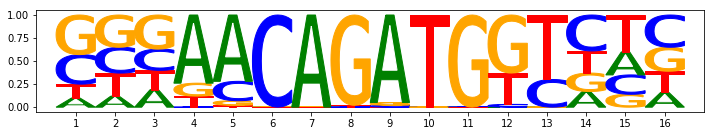

In [22]:
seqlogo_fig(pwm);

## Predict binding with pwm scan model

In this section, you will implement a PWM scan model, which is a convolution operation

In [23]:
# A naiv version
def pwm_scan(sequence, pwm, pad=0, stride=1):
    """ sequence: (N, L, 4)
    output length given by L' = 1 + (L + 2*P - F) / stride
    """
    pwm = np.log(pwm) # transform frequencies into log scale to have an additive model
    assert len(sequence.shape) == 3
    assert pwm.shape[1] == 4
    N, L, _ = sequence.shape
    F, _ = pwm.shape
    S = stride
    assert (L + 2 * pad - F) % S == 0, "Size not fit."
    L_out = int(1 + (L + 2 * pad - F) / S)
    out = np.zeros((N, L_out))

    x_pad = np.pad(sequence, ((0, 0), (1, 1), (0,0)), mode='constant')

    ###################################################################
    # Fill your code here
    # Write the PWM scan (convolution) operation, store the output
    # into `out` array.
    
    
    ###################################################################


    return out

In [24]:
scores = pwm_scan(x_test, pwm)

In [25]:
scores.shape

(3200, 485)

## Summarize PWM scan ouput per sequence with two pooling strategies

Try two pooling strategies:
  * GloabalAveragePooling: Take average score per sequence 
  * GloabalMaxPooling: take max activation score

### Averange Pooling

In [26]:
mean_scores = ## Fill your code here

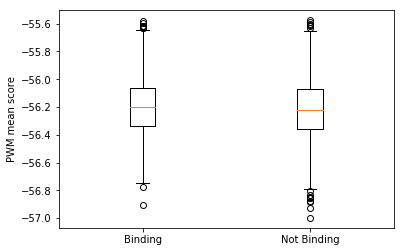

In [27]:
plt.boxplot([mean_scores[y_test.flatten()], mean_scores[~y_test.flatten()]], labels=['Binding','Not Binding'])
plt.ylabel("PWM mean score")
plt.show()

### Max Pooling

In [28]:
max_scores = ## Fill your code here

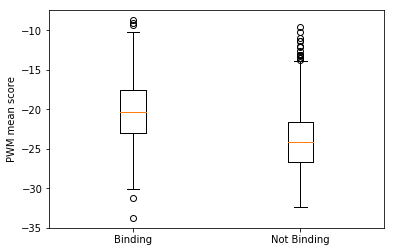

In [29]:
plt.boxplot([max_scores[y_test.flatten()], max_scores[~y_test.flatten()]], labels=['Binding','Not Binding'])
plt.ylabel("PWM mean score")
plt.show()

### Check performance

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score

In [31]:
roc = {}
roc['mean_roc'] = roc_auc_score(y_test, mean_scores)
roc['max_roc'] = roc_auc_score(y_test, max_scores)

In [32]:
fpr = {}
tpr = {}
fpr['Mean'], tpr["Mean"], _ = roc_curve(y_test, mean_scores)
fpr['Max'], tpr["Max"], _ = roc_curve(y_test, max_scores)

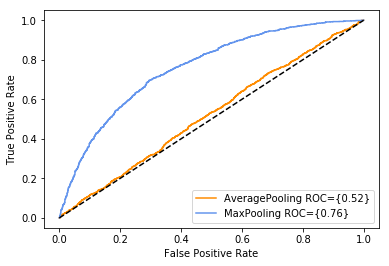

In [33]:
plt.plot(fpr['Mean'], tpr["Mean"], color='darkorange', 
        label = 'AveragePooling ROC={%0.2f}' % roc['mean_roc'])
plt.plot(fpr['Max'], tpr["Max"], color='cornflowerblue', 
        label = 'MaxPooling ROC={%0.2f}' % roc['max_roc'])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

## Build a convolutional neural network

The following code will give you an end-to-end example for training, evaluating and visualizing convolutional neural networks for DNA sequence models.

### Define the model

We'll use Keras (https://keras.io), a popular deep learning library wrapping frameworks like TensorFlow to define and train a neural network. After running the code, go to the documentation and read more about Keras.


https://keras.io/getting-started/sequential-model-guide/

We will now implement a neural network (sketch below) consisting of 16 convolutional filters whose outputs are  transfomed by the ReLU activation function ($\text{ReLU}(x) = \max(0,x)$) . On each of the 16 vectors, we keep the maximal value ("max pooling") giving a us 16-long vector. We then perform a linear transformation of this 16-long vector into a single scalar ("Dense layer") which we map to the $[0,1]$ interval with sigmoid activation function $\text{sigm}(x) = \frac{1}{1+\exp(-x)} $ . The interpratation of the output is the probability that the sequence is bound by the transcription factor TAL1.

In [34]:
## required keras modules
from keras.models import Model, load_model, Sequential
import keras.layers as kl
import keras.optimizers as ko

For the convolution operation, we will use  `ConvDNA` from `concise` package. It offers convenient functions to visualize the learned convolution filters.

In [35]:
import concise.layers as cl

Model achitecture: ConvDNA (which is Conv1D) --> GlobalMaxPooling1D  -->  Dense --> Sigmoid

In [36]:
model = Sequential()
###################################################################
# Fill your code here
# Use model.add() to add layers
# ConvDNA: cl.ConvDNA()
# GlobalMaxPooling1D: kl.GlobalMaxPooling1D()
# Dense: kl.Dense()
# Sigmoid: kl.Activation('sigmoid')
###################################################################

In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convDNA (ConvDNA)            (None, 486, 1)            61        
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 1)                 0         
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [38]:
model.compile(optimizer="adam", loss="binary_crossentropy")

from keras.callbacks import EarlyStopping

model.fit(x=x_train, y=y_train, epochs=300, verbose=2,
          callbacks=[EarlyStopping(patience=3)],
          validation_split=.2
         )

Train on 10240 samples, validate on 2560 samples
Epoch 1/300
 - 2s - loss: 0.7228 - val_loss: 0.6934
Epoch 2/300
 - 2s - loss: 0.6930 - val_loss: 0.6936
Epoch 3/300
 - 2s - loss: 0.6929 - val_loss: 0.6938
Epoch 4/300
 - 2s - loss: 0.6927 - val_loss: 0.6938


In [39]:
model.layers[0]

<Figure size 1440x216 with 0 Axes>

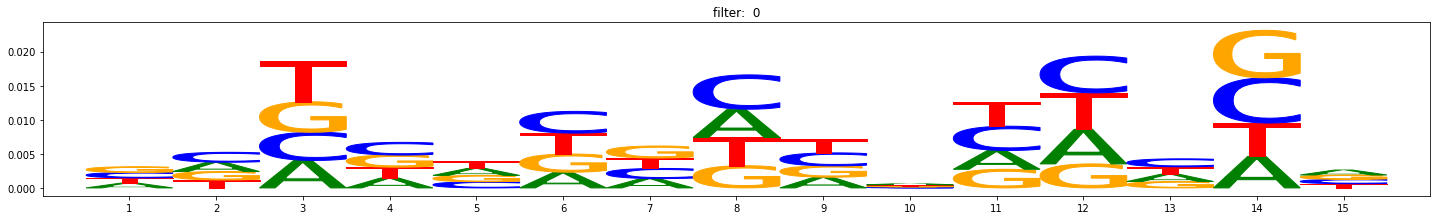

In [40]:
model.layers[0].plot_weights(figsize=(20, 3), plot_type="motif_pwm_info");

In [41]:
y_test_pred = model.predict(x_test)

roc['ConvNet1Motif'] = roc_auc_score(y_test, y_test_pred)

In [42]:
fpr['ConvNet1Motif'], tpr["ConvNet1Motif"], _ = roc_curve(y_test, y_test_pred)

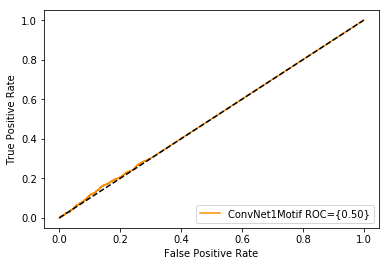

In [43]:
plt.plot(fpr['ConvNet1Motif'], tpr["ConvNet1Motif"], color='darkorange', 
        label = 'ConvNet1Motif ROC={%0.2f}' % roc['ConvNet1Motif'])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

### Build a model with 4 filters

In [54]:
model = Sequential()
###################################################################
# Fill your code here
# Use model.add() to add layers
# ConvDNA: cl.ConvDNA()
# GlobalMaxPooling1D: kl.GlobalMaxPooling1D()
# Dense: kl.Dense()
# Sigmoid: kl.Activation('sigmoid')
###################################################################

In [55]:
model.compile(optimizer="adam", loss="binary_crossentropy")

from keras.callbacks import EarlyStopping

model.fit(x=x_train, y=y_train, epochs=300, verbose=2,
          callbacks=[EarlyStopping(patience=3)],
          validation_split=.2
         )

Train on 10240 samples, validate on 2560 samples
Epoch 1/300
 - 2s - loss: 0.6942 - val_loss: 0.6940
Epoch 2/300
 - 2s - loss: 0.6880 - val_loss: 0.6779
Epoch 3/300
 - 2s - loss: 0.6449 - val_loss: 0.6113
Epoch 4/300
 - 2s - loss: 0.5573 - val_loss: 0.5089
Epoch 5/300
 - 2s - loss: 0.4512 - val_loss: 0.4156
Epoch 6/300
 - 2s - loss: 0.3709 - val_loss: 0.3521
Epoch 7/300
 - 2s - loss: 0.3188 - val_loss: 0.3138
Epoch 8/300
 - 2s - loss: 0.2861 - val_loss: 0.2904
Epoch 9/300
 - 2s - loss: 0.2653 - val_loss: 0.2758
Epoch 10/300
 - 2s - loss: 0.2508 - val_loss: 0.2660
Epoch 11/300
 - 2s - loss: 0.2409 - val_loss: 0.2584
Epoch 12/300
 - 2s - loss: 0.2319 - val_loss: 0.2482
Epoch 13/300
 - 2s - loss: 0.2189 - val_loss: 0.2398
Epoch 14/300
 - 2s - loss: 0.2096 - val_loss: 0.2327
Epoch 15/300
 - 2s - loss: 0.2030 - val_loss: 0.2294
Epoch 16/300
 - 2s - loss: 0.1974 - val_loss: 0.2247
Epoch 17/300
 - 2s - loss: 0.1931 - val_loss: 0.2225
Epoch 18/300
 - 2s - loss: 0.1896 - val_loss: 0.2200
Epoch 

<Figure size 1440x864 with 0 Axes>

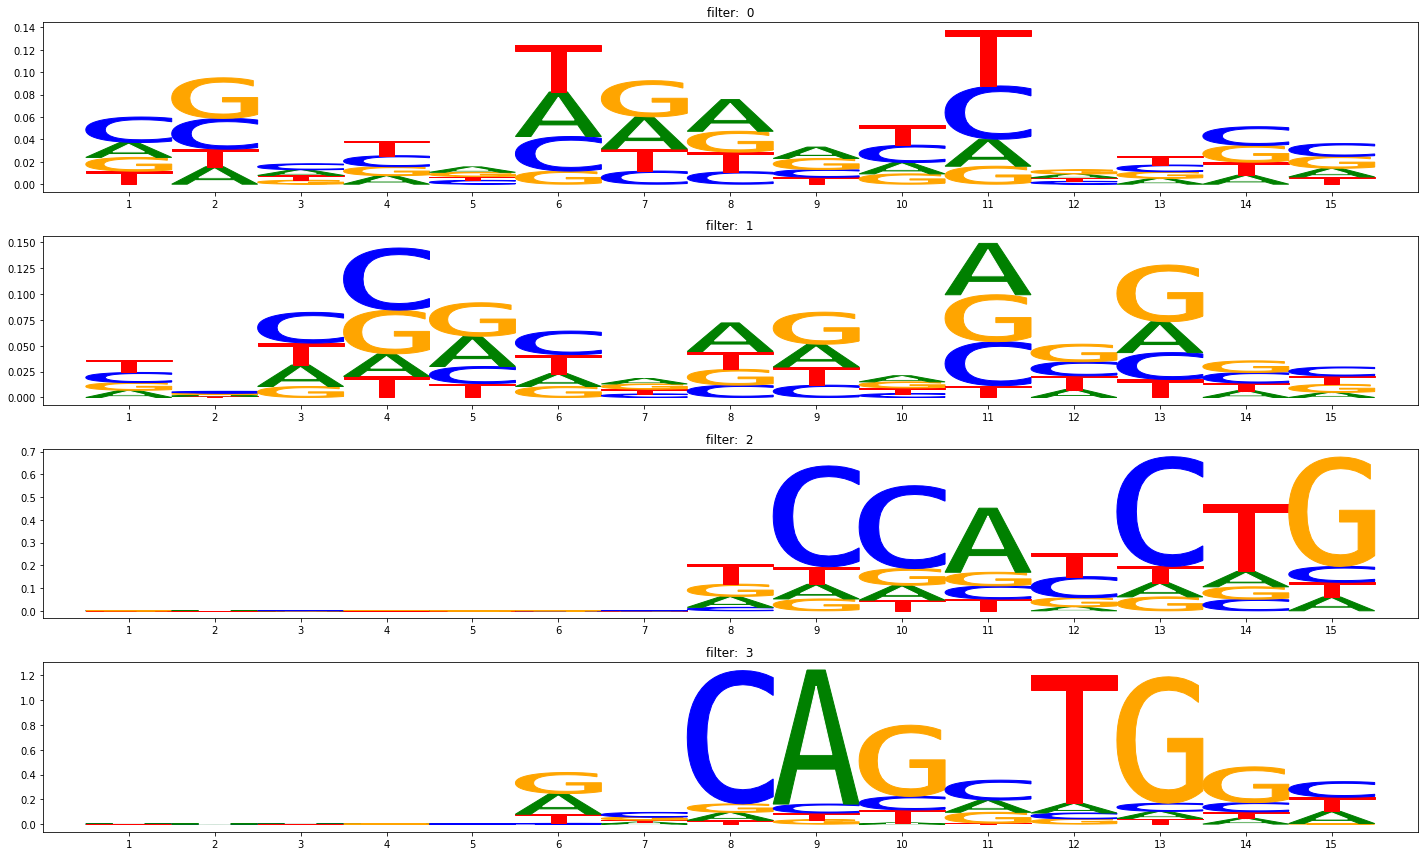

In [56]:
model.layers[0].plot_weights(figsize=(20, 12), plot_type="motif_pwm_info");

In [47]:
y_test_pred = model.predict(x_test)

roc['ConvNet16Motif'] = roc_auc_score(y_test, y_test_pred)

In [48]:
fpr['ConvNet16Motif'], tpr["ConvNet16Motif"], _ = roc_curve(y_test, y_test_pred)

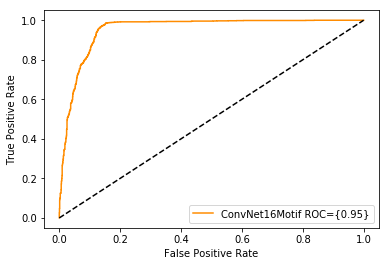

In [49]:
plt.plot(fpr['ConvNet16Motif'], tpr["ConvNet16Motif"], color='darkorange', 
        label = 'ConvNet16Motif ROC={%0.2f}' % roc['ConvNet16Motif'])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()